## Import Libraries

In [1]:
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
import time

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Using TensorFlow backend.
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\tenso

## Load Processed Data

df = pd.read_csv("processed_batch_df_individuals_over_5_pics.csv")

df.head()

# Examine the data
df.shape

## Split Training and Test Data
### For every five samples for an individual (same ID), one sample is for testing while the other four are for training

df_arr = np.array(df)

training_data_dict = dict()
testing_data_dict = dict()

# Initialize columns
for col in tqdm(df.columns):
    training_data_dict[col] = list()
    testing_data_dict[col] = list()

temp_id = ""
    
for i in tqdm(range(df.shape[0])):
    curr_id = df_arr[i][3]
    
    if temp_id != curr_id:
        # Different ID, add to testing_data
        j = 0
        for col in df.columns:
            testing_data_dict[col].append(df_arr[i][j])
            j = j+1
        
        temp_id = curr_id
    else:
        # Same ID, add to training_data
        j = 0
        for col in df.columns:
            training_data_dict[col].append(df_arr[i][j])
            j = j+1
        
# Release memory of df_arr
df_arr = None  
    
training_data = pd.DataFrame(training_data_dict)
testing_data = pd.DataFrame(testing_data_dict)

training_data.to_csv('train_data.csv')
testing_data.to_csv('test_data.csv')

## Divide the Training and Test Data Into Features, Species Labels, and IDs

# Divide into features, ids, and species
test_features = testing_data.drop(columns=['index', 'image','species','individual_id','aspect_ratio'])
test_labels = testing_data['species']
test_ids = testing_data['individual_id']

test_labels.to_csv('test_labels.csv')
test_features.to_csv('test_features.csv')
test_ids.to_csv('test_ids.csv')

train_features = training_data.drop(columns=['index', 'image','species','individual_id','aspect_ratio'])
train_labels = training_data['species']
train_ids = training_data['individual_id']

train_labels.to_csv('train_labels.csv')
train_features.to_csv('train_features.csv')
train_ids.to_csv('train_ids.csv')

## Load the Data
### This is called first durting testing to avoid repetitive processing of the original data

In [2]:
# Load saved split data
test_labels = pd.read_csv("test_labels.csv")
test_features = pd.read_csv("test_features.csv")
test_ids = pd.read_csv("test_ids.csv")

train_labels = pd.read_csv("train_labels.csv")
train_features = pd.read_csv("train_features.csv")
train_ids = pd.read_csv("train_ids.csv")

In [3]:
# Remove 'Unnamed: 0' columns
test_labels.drop('Unnamed: 0', inplace=True, axis=1)
test_features.drop('Unnamed: 0', inplace=True, axis=1)
test_ids.drop('Unnamed: 0', inplace=True, axis=1)

train_labels.drop('Unnamed: 0', inplace=True, axis=1)
train_features.drop('Unnamed: 0', inplace=True, axis=1)
train_ids.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
# Convert to arrays
test_labels = np.array(test_labels).reshape(-1, 1)
test_features = np.array(test_features)
test_ids = np.array(test_ids).reshape(-1, 1)

train_labels = np.array(train_labels).reshape(-1, 1)
train_features = np.array(train_features)
train_ids = np.array(train_ids).reshape(-1, 1)

## Define Test Methods

In [5]:
def test_model_accuracy(model, train_features, train_labels, test_features, test_labels):
    # Fit model
    model.fit(train_features, train_labels)
    
    # Predict
    y_predict = model.predict(test_features)
        
    # Get accuracy
    accuracy = accuracy_score(test_labels, y_predict)*100
    f1 = f1_score(test_labels, y_predict, average="weighted")
    
    return accuracy, f1

def test_cluster_accuracy(model, train_features, test_features):
    
    train_labels = model.fit(train_features).predict(train_features)
    model.fit(train_features)
        
    # Predict using k = k_value
    y_predict = model.predict(test_features)
    
    test_labels =  model.fit(test_features).predict(test_features)
        
    # Get accuracy for each k_value
    accuracy = accuracy_score(test_labels, y_predict)*100
    f1 = f1_score(test_labels, y_predict, average="weighted")
    return accuracy, f1

def plot_scores(param_list, score1_list, score2_list, param_name, score1_name, score2_name, model_name, is_id):
    fig = plt.figure()
    fig.suptitle(model_name + " : " + score1_name + " vs. Value of " + param_name)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Value of " + param_name)
    ax.set_ylabel(score1_name)
    
    if True == is_id:
        ax.set_ylim(0,40)
    else:
        ax.set_ylim(0,100)
        
    labels = list(map(str, param_list))
    ax.bar(labels, score1_list)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    fig = plt.figure()
    fig.suptitle(model_name + " : " + score2_name + " vs. Value of " + param_name)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Value of " + param_name)
    ax.set_ylabel(score2_name)
    
    if True == is_id:
        ax.set_ylim(0,0.35)
    else:
        ax.set_ylim(0,1)
        
    labels = list(map(str, param_list))
    ax.bar(labels, score2_list)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
  7%|▋         | 1/15 [00:10<02:28, 10.58s/it]C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\neighbors\_classification.py:179: Data

 93%|█████████▎| 14/15 [02:29<00:10, 10.75s/it]C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
100%|██████████| 15/15 [02:40<00:00, 10.70s/it]


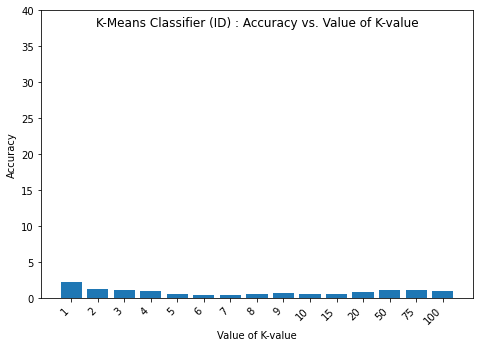

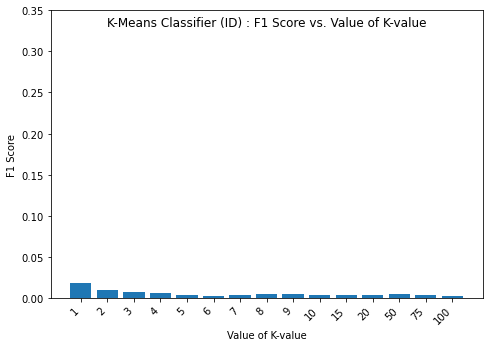

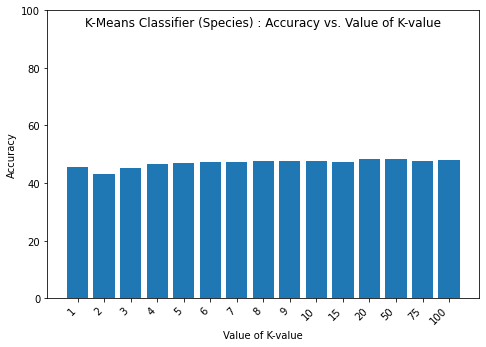

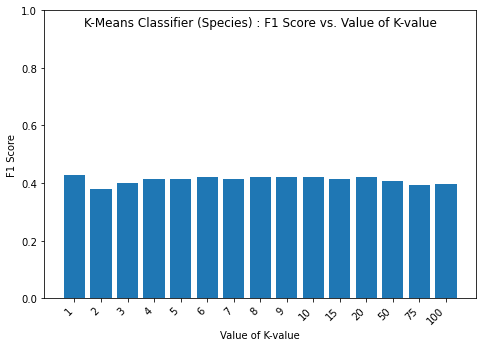

In [6]:
#  K-Nearest Neighbors model
knnmodel = KNeighborsClassifier(n_neighbors=1)

k_values = [1,2,3,4,5,6,7,8,9,10,15,20,50,75,100]
knn_acc = list()
knn_f1_list = list()
knn_species_acc = list()
knn_species_f1_list = list()

for i in tqdm(range(len(k_values))):
    knnmodel = KNeighborsClassifier(n_neighbors=k_values[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        knnmodel,
        train_features,
        train_ids,
        test_features,
        test_ids
    )
    
    knn_f1_list.append(f1)
    knn_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        knnmodel,
        train_features,
        train_labels,
        test_features,
        test_labels
    )
    
    knn_species_f1_list.append(f1)
    knn_species_acc.append(ac)


plot_scores(k_values, knn_acc, knn_f1_list, "K-value", "Accuracy", "F1 Score", "K-Means Classifier (ID)", True)
plot_scores(k_values, knn_species_acc, knn_species_f1_list, "K-value", "Accuracy", "F1 Score", "K-Means Classifier (Species)", False)

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 11%|█         | 1/9 [00:30<04:03, 30.45s/it]C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-ve

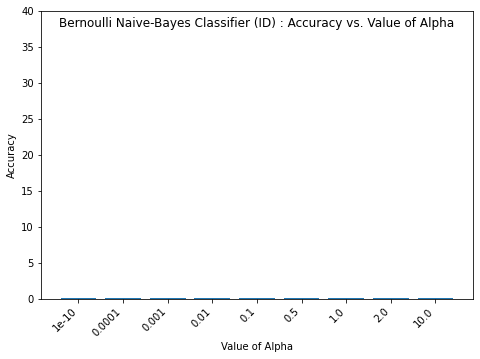

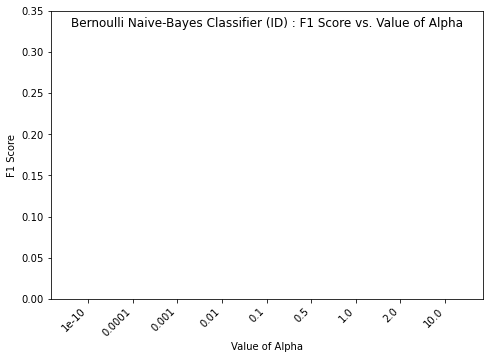

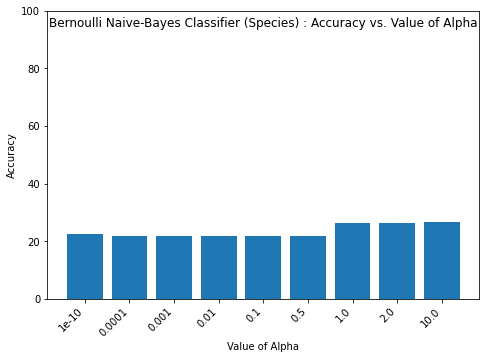

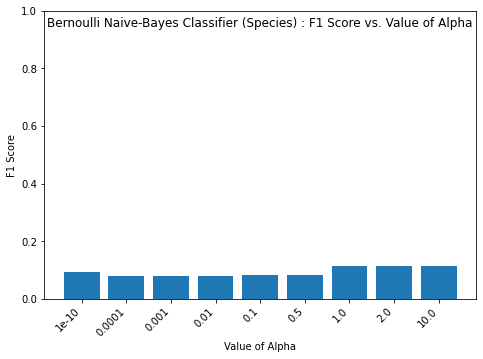

In [7]:
# Bernoulli Naive-Bayes
alpha_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
nb_acc = list()
nb_f1_list = list()
nb_species_acc = list()
nb_species_f1_list = list()

for i in tqdm(range(len(alpha_list))):
    nbmodel = BernoulliNB(alpha=alpha_list[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        nbmodel,
        train_features,
        train_ids,
        test_features,
        test_ids
    )
    
    nb_f1_list.append(f1)
    nb_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        nbmodel,
        train_features,
        train_labels,
        test_features,
        test_labels
    )
    
    nb_species_f1_list.append(f1)
    nb_species_acc.append(ac)

plot_scores(alpha_list, nb_acc, nb_f1_list, "Alpha", "Accuracy", "F1 Score", "Bernoulli Naive-Bayes Classifier (ID)", True)
plot_scores(alpha_list, nb_species_acc, nb_species_f1_list, "Alpha", "Accuracy", "F1 Score", "Bernoulli Naive-Bayes Classifier (Species)", False)

# Decision tree
max_depth_list = [None]
dt_acc = list()
dt_f1_list = list()
dt_species_acc = list()
dt_species_f1_list = list()
    
for i in tqdm(range(len(max_depth_list))):
    dt = DecisionTreeClassifier(max_depth=max_depth_list[i], criterion='entropy')
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        dt,
        train_features,
        train_ids,
        test_features,
        test_ids
    )
    
    dt_f1_list.append(f1)
    dt_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        dt,
        train_features,
        train_labels,
        test_features,
        test_labels
    )
    
    dt_species_f1_list.append(f1)
    dt_species_acc.append(ac)


plot_scores(max_depth_list, dt_acc, dt_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Decision Tree Classifier (ID)", True)
plot_scores(max_depth_list, dt_species_acc, dt_species_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Decision Tree Classifier (Species)", False)

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 25%|██▌       | 1/4 [13:34<40:44, 814.73s/it]C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-v

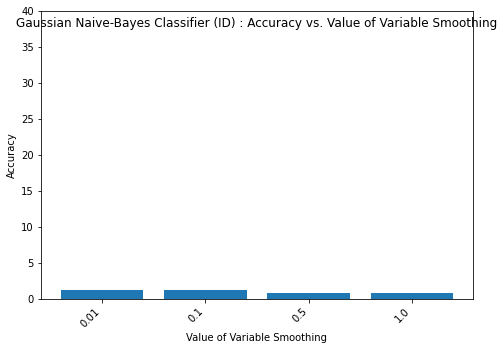

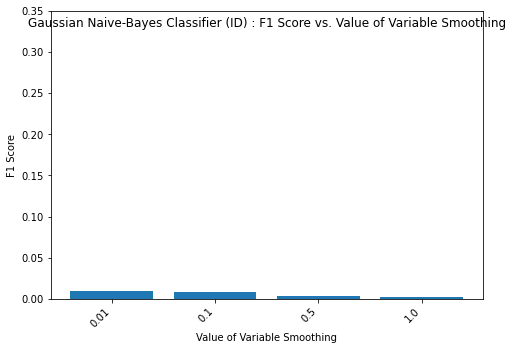

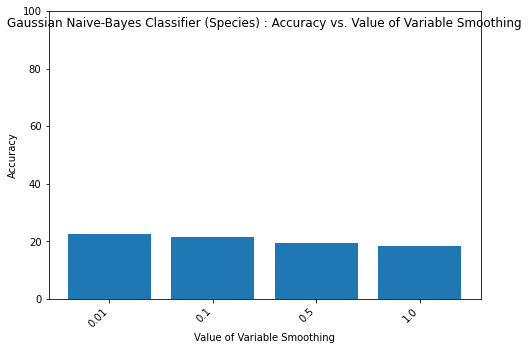

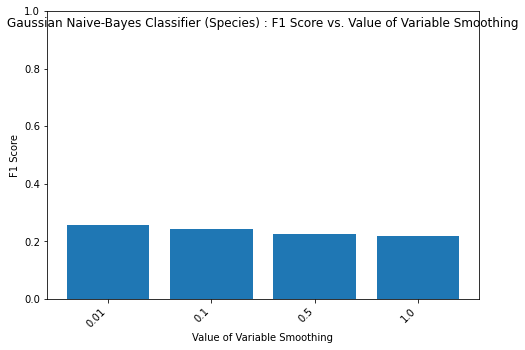

In [8]:
# Gaussian Naive-Bayes
var_smoothing_list = [0.01, 0.1, 0.5, 1.0]
gb_acc = list()
gb_f1_list = list()
gb_species_acc = list()
gb_species_f1_list = list()

for i in tqdm(range(len(var_smoothing_list))):
    gbmodel = GaussianNB(var_smoothing=var_smoothing_list[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        gbmodel,
        train_features,
        train_ids,
        test_features,
        test_ids
    )
    
    gb_f1_list.append(f1)
    gb_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        gbmodel,
        train_features,
        train_labels,
        test_features,
        test_labels
    )
    
    gb_species_f1_list.append(f1)
    gb_species_acc.append(ac)


plot_scores(var_smoothing_list, gb_acc, gb_f1_list, "Variable Smoothing", "Accuracy", "F1 Score", "Gaussian Naive-Bayes Classifier (ID)", True)
plot_scores(var_smoothing_list, gb_species_acc, gb_species_f1_list, "Variable Smoothing", "Accuracy", "F1 Score", "Gaussian Naive-Bayes Classifier (Species)", False)

# LogisticRegression
c_list = [0.01, 0.1, 0.5, 1.0]
lr_acc = list()
lr_f1_list = list()
lr_species_acc = list()
lr_species_f1_list = list()
    
for i in tqdm(range(len(c_list))):
    lrmodel = LogisticRegression(C=c_list[i], solver="liblinear", multi_class="auto")
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        lrmodel,
        train_features,
        train_ids,
        test_features,
        test_ids
    )
    
    lr_f1_list.append(f1)
    lr_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        lrmodel,
        train_features,
        train_ids,
        test_features,
        test_ids
    )
    
    lr_species_f1_list.append(f1)
    lr_species_acc.append(ac)


plot_scores(c_list, lr_acc, lr_f1_list, "L2 Strength", "Accuracy", "F1 Score", "Logistic Regression Classifier (ID)", True)
plot_scores(c_list, lr_species_acc, lr_species_f1_list, "L2 Strength", "Accuracy", "F1 Score", "Logistic Regression Classifier (Species)", False)

In [9]:
# K-Means clustering
#kmeans = KMeans(1350, random_state=0)

#kmeans_acc, kmeans_f1 = test_cluster_accuracy(kmeans, train_features, test_features)
#kmeans_species_acc, kmeans_species_f1 = test_cluster_accuracy(kmeans, train_features, test_features)

In [10]:
# Gaussian Mixture Model clustering
#gmm = GMM(n_components=26)

#print(test_cluster_accuracy(gmm, train_features_shuffled, test_features_shuffled))

# Neural Network

def test_neural_network():
    model = Sequential()
    model.add(Dense(12, input_dim=65536, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model and calculate its accuracy:
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy']) 

    # Print a summary of the Keras model:
    #model.summary()
    
    # Convert labels to integers
    
    le = LabelEncoder()
    train_labels = le.fit_transform(train_labels_shuffled)
    test_labels = le.fit_transform(test_labels_shuffled)
    
    model.fit(train_features_shuffled, train_labels, batch_size=32, epochs=150)

    y_predict = model.fit(test_features_shuffled)
    
    return accuracy_score(test_labels, y_predict)*100


print(test_neural_network())

In [11]:
# Prepare compilation

result_labels = ["kNN", "BernoulliNB", "GaussianNB"]
# Omitted "Decision Tree", "Logistic Regression", "K-Means"

id_accuracies = list()
id_accuracies.append(max(knn_acc))
id_accuracies.append(max(nb_acc))
#id_accuracies.append(max(dt_acc))
id_accuracies.append(max(gb_acc))
#id_accuracies.append(max(lr_acc))
#id_accuracies.append(kmeans_acc)

id_f1s = list()
id_f1s.append(max(knn_f1_list))
id_f1s.append(max(nb_f1_list))
#id_f1s.append(max(dt_f1_list))
id_f1s.append(max(gb_f1_list))
#id_f1s.append(max(lr_f1_list))
#id_f1s.append(kmeans_f1)

id_species_accuracies = list()
id_species_accuracies.append(max(knn_species_acc))
id_species_accuracies.append(max(nb_species_acc))
#id_species_accuracies.append(max(dt_species_acc))
id_species_accuracies.append(max(gb_species_acc))
#id_species_accuracies.append(max(lr_species_acc))
#id_species_accuracies.append(kmeans_species_acc)

id_species_f1s = list()
id_species_f1s.append(max(knn_species_f1_list))
id_species_f1s.append(max(nb_species_f1_list))
#id_species_f1s.append(max(dt_species_f1_list))
id_species_f1s.append(max(gb_species_f1_list))
#id_species_f1s.append(max(lr_species_f1_list))
#id_species_f1s.append(kmeans_species_f1)


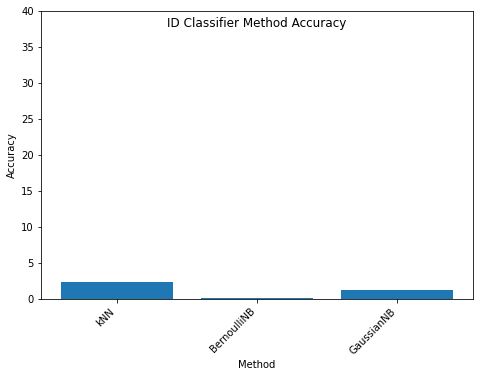

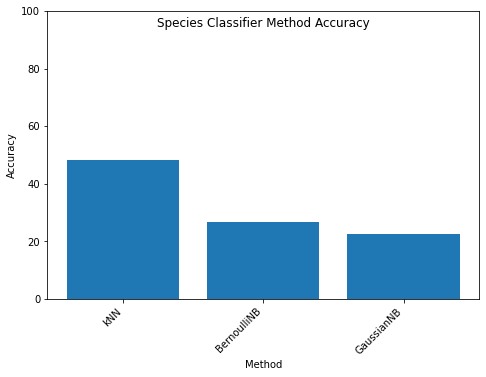

In [12]:
# Plot Accuracies
fig = plt.figure()
fig.suptitle("ID Classifier Method Accuracy")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,40)
ax.bar(result_labels, id_accuracies)
plt.xticks(rotation=45, ha='right')
plt.show()

fig = plt.figure()
fig.suptitle("Species Classifier Method Accuracy")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,100)
ax.bar(result_labels, id_species_accuracies)
plt.xticks(rotation=45, ha='right')
plt.show()

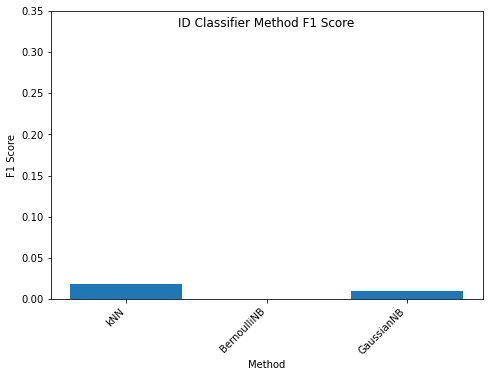

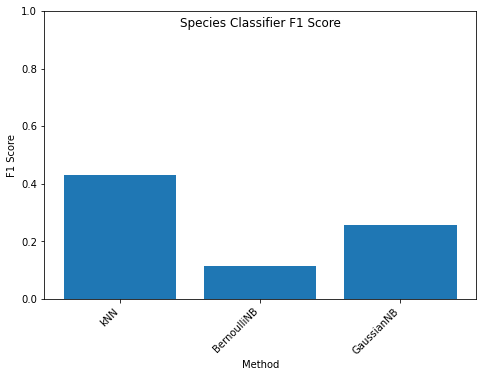

In [13]:
# Plot F1 scores
fig = plt.figure()
fig.suptitle("ID Classifier Method F1 Score")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("F1 Score")
ax.set_ylim(0,0.35)
ax.bar(result_labels, id_f1s)
plt.xticks(rotation=45, ha='right')
plt.show()

fig = plt.figure()
fig.suptitle("Species Classifier F1 Score")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("F1 Score")
ax.set_ylim(0,1)
ax.bar(result_labels, id_species_f1s)
plt.xticks(rotation=45, ha='right')
plt.show()